In [20]:
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import json
import math
from matplotlib import pyplot as plt
%matplotlib inline

In [45]:
data_dir_base = '/root/blender'
idx = 3

def get_data(data_dir_base, idx):
    # get annotation data
    annotation_file_name = 'annot_{}.json'.format(idx)
    annotation_file_path = '{}/{}/{}'.format(data_dir_base, 'annotations', annotation_file_name)
    annotation_data = json.load(open(annotation_file_path, 'rb'))

    # get segmentation data
    segmentation_file_name = 'left_{}.png'.format(idx)
    segmentation_file_path = '{}/{}/{}'.format(data_dir_base, 'mask', segmentation_file_name)
    image = Image.open(segmentation_file_path)
    mask = np.array(image)

    # get depth map data
    depth_map_file_name = 'depth_map_{}.npy'.format(idx)
    depth_map_file_path = '{}/{}/{}'.format(data_dir_base, 'depth_map', depth_map_file_name)
    depth_map = np.load(depth_map_file_path).T
    
    return { 'image': image, 'annotation_data': annotation_data, 'mask': mask, 'depth_map': depth_map }


In [46]:
data = get_data(data_dir_base, idx)
image = data['image']
annotation_data = data['annotation_data']
mask = data['mask']
depth_map = data['depth_map']

<h1> Get depth distribution across all points on the visible surface of the fish </h1>

In [47]:
hist_counts, hist_bucket_endpoints = np.histogram(depth_map[np.where(mask[:,:,0] == 253)])
print(hist_counts, hist_bucket_endpoints)
cutoff_idx = np.where(hist_counts == 0)[0][0]
cutoff = hist_bucket_endpoints[cutoff_idx]
print(cutoff_idx, cutoff)
print('Mean depth value: {}'.format(depth_map[np.where((depth_map < cutoff) & (mask[:,:,0] == 253)) ].mean()))
print('Maximum depth value: {}'.format(depth_map[np.where((depth_map < cutoff) & (mask[:,:,0] == 253)) ].max()))
print('Minimum depth value: {}'.format(depth_map[np.where((depth_map < cutoff) & (mask[:,:,0] == 253)) ].min()))

[62570 13930  3981  1536  1275   852   714     0     0    22] [  5.16873646   6.18765059   7.20656471   8.22547884   9.24439297
  10.26330709  11.28222122  12.30113535  13.32004948  14.3389636
  15.35787773]
7 12.3011353493
Mean depth value: 6.239781204806595
Maximum depth value: 12.140323638916016
Minimum depth value: 5.168736457824707


<h1> Get pixel coordinates for determining length, width, and breadth </h1>

Consider the line $l$ (in pixel space) that best fits the pixels corresponding to the fish mask $M$ according to a least-squares regression. Let $p_1 \in M$ be the point on line $l$ with the smallest $x$-coordinate, and let $p_2 \in M$ be the point on $l$ with the largest $x$-coordinate. The line segment defined by these two points corresponds to the length of the fish in pixel space. 

Now consider centroid $c = (\bar{x}, \bar{y})$ of the fish mask and the line $k$ that passes through $c$ and is perpendicular to $l$. 

In [48]:
def get_points_of_interest(mask):
    mask_values = np.where(mask[:,:,0] == 253)
    x_values = mask_values[1]
    y_values = mask_values[0]
    adj_y_values = mask.shape[0] - y_values
    mask_points = list(zip(x_values, adj_y_values))

    A = np.vstack([x_values, np.ones(len(x_values))]).T
    res = np.linalg.lstsq(A,adj_y_values)
    m, b = res[0]

    # get length endpoints
    x_lower = x_values.min()
    while x_lower < mask.shape[1]:
        adj_y_lower = int(round(m*x_lower + b))
        y_lower = mask.shape[0] - 1 - adj_y_lower
        if ((x_lower, adj_y_lower) in mask_points and (depth_map[y_lower, x_lower] < cutoff)): 
            break
        x_lower += 1

    x_upper = x_values.max()
    while x_upper > 0:
        adj_y_upper = int(round(m*x_upper + b))
        y_upper = mask.shape[0] - 1 - adj_y_upper
        if ((x_upper, adj_y_upper) in mask_points and (depth_map[y_upper, x_upper] < cutoff)):
            break
        x_upper -= 1

    y_lower = mask.shape[0] - adj_y_lower
    y_upper = mask.shape[0] - adj_y_upper
    length_endpoint_1 = (x_lower, y_lower)
    length_endpoint_2 = (x_upper, y_upper)

    # get width endpoints
    m = -1 / float(m)
    b = adj_y_values.mean() - m*x_values.mean()

    adj_y_lower = adj_y_values.min()
    while adj_y_lower < mask.shape[0]:
        x_lower = int(round((adj_y_lower - b)/float(m)))
        y_lower = mask.shape[0] - 1 - adj_y_lower
        if ((x_lower, adj_y_lower) in mask_points and (depth_map[y_lower, x_lower] < cutoff)):
            break
        adj_y_lower += 1


    adj_y_upper = adj_y_values.max()
    while adj_y_upper > 0:
        x_upper = int(round((adj_y_upper - b)/float(m)))
        y_upper = mask.shape[0] - 1 - adj_y_upper
        if ((x_upper, adj_y_upper) in mask_points and (depth_map[y_upper, x_upper] < cutoff)):
            break
        adj_y_upper -= 1

    # y_lower = mask.shape[0] - 1 - adj_y_lower
    # y_upper = mask.shape[0] - 1 - adj_y_upper
    width_endpoint_1 = (x_lower, y_lower)
    width_endpoint_2 = (x_upper, y_upper)

    # get centroid coordinates
    x_centroid = mask_values[1].mean()
    y_centroid = mask_values[0].mean()
    centroid = (x_centroid, y_centroid)
    return {
        'length_endpoint_1': length_endpoint_1,
        'length_endpoint_2': length_endpoint_2,
        'width_endpoint_1': width_endpoint_1,
        'width_endpoint_2': width_endpoint_2,
        'centroid': centroid
    }

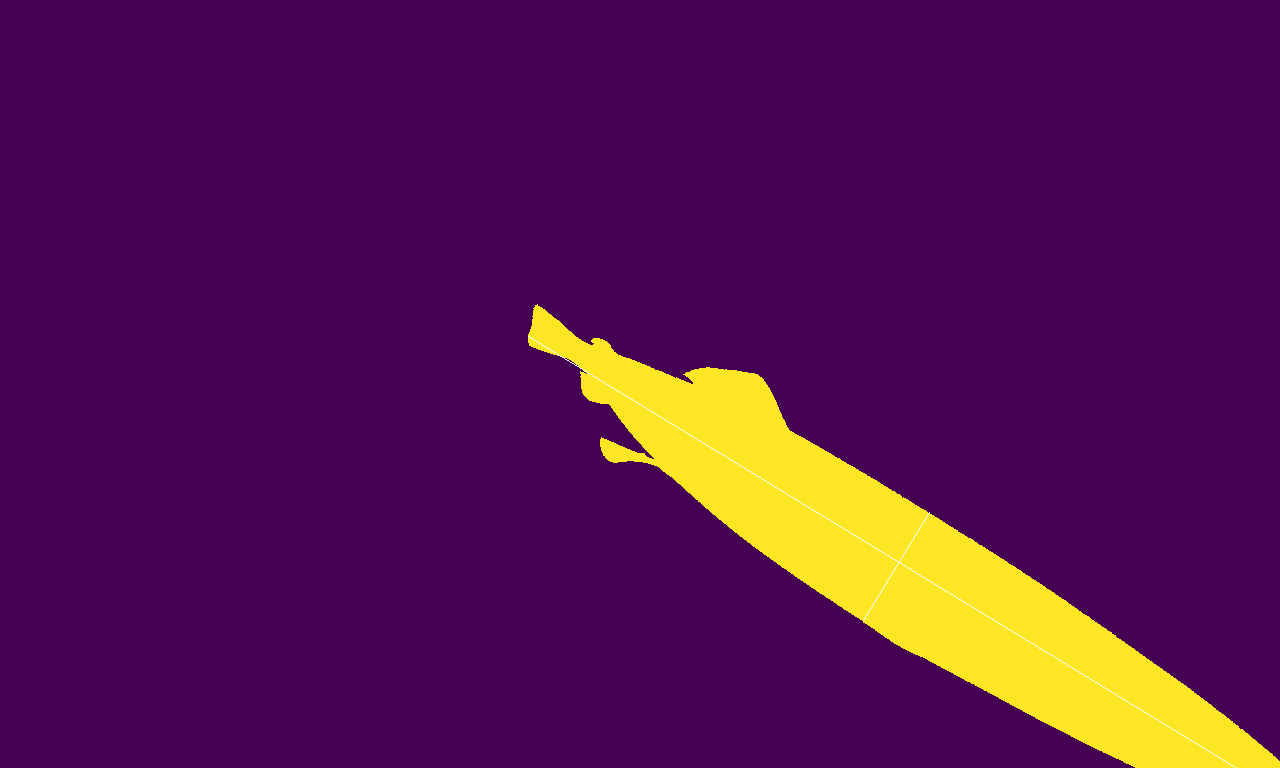

In [49]:
results = get_points_of_interest(mask)
length_endpoint_1 = results['length_endpoint_1']
length_endpoint_2 = results['length_endpoint_2']
width_endpoint_1 = results['width_endpoint_1']
width_endpoint_2 = results['width_endpoint_2']
centroid = results['centroid']
draw = ImageDraw.Draw(image)
draw.line((length_endpoint_1[0], length_endpoint_1[1], length_endpoint_2[0], length_endpoint_2[1]), fill=255)
draw.line((width_endpoint_1[0], width_endpoint_1[1], width_endpoint_2[0], width_endpoint_2[1]), fill=255)
image

<h1> Get world coordinates of head, tail and fish centroid on visible surface </h1>

In [37]:
focal_length = 0.1
baseline = 6.5
image_sensor_width = 3.2
image_sensor_height = 1.8
px_count_width = mask.shape[0]
px_count_height = mask.shape[1]


<h1> Get length and width in world space </h1>

In [38]:
def convert_to_world_point(x, y, depth_map, mask):
    image_center_x = mask.shape[1] / 2.0
    image_center_y = mask.shape[0] / 2.0
    px_x = x - image_center_x
    px_z = image_center_y - y
    sensor_x = px_x * (image_sensor_width / px_count_width)
    sensor_z = px_z * (image_sensor_height / px_count_height)

    d = depth_map[y, x]
    world_y = d / (math.sqrt(1 + ((sensor_x**2 + sensor_z**2)/(focal_length**2))))
    world_x = (world_y * sensor_x) / focal_length
    world_z = (world_y * sensor_z) / focal_length
    
    return (world_x, world_y, world_z)

def distance_between_points(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

In [39]:
length_endpoint_1_world = convert_to_world_point(length_endpoint_1[0], length_endpoint_1[1], depth_map, mask)
length_endpoint_2_world = convert_to_world_point(length_endpoint_2[0], length_endpoint_2[1], depth_map, mask)
width_endpoint_1_world = convert_to_world_point(width_endpoint_1[0], width_endpoint_1[1], depth_map, mask)
width_endpoint_2_world = convert_to_world_point(width_endpoint_2[0], width_endpoint_2[1], depth_map, mask)
centroid_world = convert_to_world_point(int(round(centroid[0])), int(round(centroid[1])), depth_map, mask)
length = distance_between_points(length_endpoint_1_world, length_endpoint_2_world)
width = distance_between_points(width_endpoint_1_world, width_endpoint_2_world)


<h1> Extract features for all fish in the Blender dataset </h1>

In [51]:
data_dir_base = '/root/blender'
COMPLETE_SAMPLE_SIZE = 4007
df = pd.DataFrame()
for idx in range(COMPLETE_SAMPLE_SIZE):
    if idx % 100 == 0:
        print(idx)
    data = get_data(data_dir_base, idx)
    annotation_data = data['annotation_data']
    mask = data['mask']
    depth_map = data['depth_map']
    
    results = get_points_of_interest(mask)
    length_endpoint_1 = results['length_endpoint_1']
    length_endpoint_2 = results['length_endpoint_2']
    width_endpoint_1 = results['width_endpoint_1']
    width_endpoint_2 = results['width_endpoint_2']
    centroid = results['centroid']
    
    length_endpoint_1_world = convert_to_world_point(length_endpoint_1[0], length_endpoint_1[1], depth_map, mask)
    length_endpoint_2_world = convert_to_world_point(length_endpoint_2[0], length_endpoint_2[1], depth_map, mask)
    width_endpoint_1_world = convert_to_world_point(width_endpoint_1[0], width_endpoint_1[1], depth_map, mask)
    width_endpoint_2_world = convert_to_world_point(width_endpoint_2[0], width_endpoint_2[1], depth_map, mask)
    centroid_world = convert_to_world_point(int(round(centroid[0])), int(round(centroid[1])), depth_map, mask)
    length = distance_between_points(length_endpoint_1_world, length_endpoint_2_world)
    width = distance_between_points(width_endpoint_1_world, width_endpoint_2_world)
    
    ground_truth_length = annotation_data['length']
    ground_truth_width = annotation_data['height']
    ground_truth_breadth = annotation_data['width']

    line_to_append = { 
        'predicted_length': length, 
        'predicted_width': width,
        'ground_truth_length': ground_truth_length,
        'ground_truth_width': ground_truth_width,
        'ground_truth_breadth': ground_truth_breadth
    }
    df = df.append(line_to_append, ignore_index=True)
    


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000


In [58]:
print(df.predicted_length.corr(df.ground_truth_length))
print(df.predicted_width.corr(df.ground_truth_width))


0.328528465888
-0.0811438991024
